In [13]:
# Welcome to the object detection tutorial !

# Imports
import cv2
import numpy as np
import os
import sys
# run on CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
from distutils.version import StrictVersion
from collections import defaultdict
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
# from tensorflow.python.client import device_lib
# print (device_lib.list_local_devices())
# with tf.Session() as sess:
#     devices = sess.list_devices()
# print(devices)


In [3]:

# title of our window
title = "CAPTCHA"

# Env setup
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util



In [4]:

# Model preparation 
PATH_TO_FROZEN_GRAPH = 'frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'CAPTCHA_labelmap.pbtxt'
NUM_CLASSES = 37


# Load a (frozen) Tensorflow model into memory.
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


W0717 09:59:34.834694 89740 deprecation_wrapper.py:119] From C:\Tensorflow\research\object_detection\utils\label_map_util.py:132: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [5]:

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [6]:

# Detection
def decode_captcha(image_np, average_distance_error=3):
    
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Open image
#             image_np = cv2.imread(image)
            
#             preprocess_image(image_np)
            
#             # To get real color we do this:
            image_np = cv2.resize(image_np, (600,200))
            image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Visualization of the results of a detection.
            (boxes, scores, classes, num_detections) = sess.run(
              [boxes, scores, classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=2)
            # Show image with detection
#             cv2.imshow(title, cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
#             cv2.waitKey(10000)
            plt.figure(figsize=(5,5))
            plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
#             plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
            # Save image with detection
#             cv2.imwrite("Predicted_captcha.jpg", cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
            
            captcha_array = []
            # loop our all detection boxes
            for i,b in enumerate(boxes[0]):
                for Symbol in range(37):
                    if classes[0][i] == Symbol: # check if detected class equal to our symbols
                        if scores[0][i] >= 0.50: # do something only if detected score more han 0.65
                                            # x-left        # x-right
                            mid_x = (boxes[0][i][1]+boxes[0][i][3])/2 # find x coordinates center of letter
                            # to captcha_array array save detected Symbol, middle X coordinates and detection percentage
                            captcha_array.append([category_index[Symbol].get('name'), mid_x, scores[0][i]])

            # rearange array acording to X coordinates datected
            for number in range(20):
                for captcha_number in range(len(captcha_array)-1):
                    if captcha_array[captcha_number][1] > captcha_array[captcha_number+1][1]:
                        temporary_captcha = captcha_array[captcha_number]
                        captcha_array[captcha_number] = captcha_array[captcha_number+1]
                        captcha_array[captcha_number+1] = temporary_captcha


            # Find average distance between detected symbols
            average = 0
            captcha_len = len(captcha_array)-1
            while captcha_len > 0:
                average += captcha_array[captcha_len][1]- captcha_array[captcha_len-1][1]
                captcha_len -= 1
            # Increase average distance error
            average = average/(len(captcha_array)+average_distance_error)

            
            captcha_array_filtered = list(captcha_array)
            captcha_len = len(captcha_array)-1
            while captcha_len > 0:
                # if average distance is larger than error distance
                if captcha_array[captcha_len][1]- captcha_array[captcha_len-1][1] < average:
                    # check which symbol has higher detection percentage
                    if captcha_array[captcha_len][2] > captcha_array[captcha_len-1][2]:
                        del captcha_array_filtered[captcha_len-1]
                    else:
                        del captcha_array_filtered[captcha_len]
                captcha_len -= 1

            # Get final string from filtered CAPTCHA array
            captcha_string = ""
            for captcha_letter in range(len(captcha_array_filtered)):
                captcha_string += captcha_array_filtered[captcha_letter][0]
            plt.title(captcha_string)
            plt.show()
            return captcha_string

In [8]:

for i in [
#             928,932,938,940,946,952,970,981
#           914,915,917,923,925,931,934, 936, 941, 943
           935,937, 939, 942, 947, 948, 949, 956, 957
#     36, 39, 54, 62, 93, 94
         ]:
#     image_np = cv2.imread("../captcha/captha{}.png".format(i))
    print(decode_captcha("../captcha/captha{}.png".format(i)))


TypeError: src is not a numpy array, neither a scalar

In [16]:
# gif= 'data:image/Gif;base64,iVBORw0KGgoAAAANSUhEUgAAAEsAAAAZCAYAAAB5CNMWAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAAHJSURBVFhH7ZYxbsMwDEV7dB8gm6ds2bx58+gxa9bMOUDOoOAZ/S0jULY5RC4KEXiwLFES+U0p+eq6LjX20cQK0MQK0MQK0MQKsEus8/m8sDbm0fe9Owe8cd7zNeB0Or35HcWqWOM4pufzmWSPx2MJ3vrY8dzwt75inmd3nHfP2MPbuzZFsS6Xy3eoKd1ut3S/35c2gdsvLbFIJod5dk2geuwcO8Y7JnFEyb82RbFIFLterz99Ssb2KZG9X11rYHnyGqPybD8fJ7rPJyiK5QXuHZ9IEoiMqUqjYoHtr01RLCVkq0jVZoOWWPiRpEU+oGONIAirtvWRWKxJW2iPfM3aFMUahmEJkEBp28uep/zUl5v1ASVNlWyJ5Rlzp2l6869NUSzQsZEpGU+stcrSOkp2Syz88RGsJeOj2Tk1WRUL9N+Hp4K2SUosfOw8i3x4ChltzZVYVmihsVzgmhTF4o4haFv63j2mxLfEypHR/hdiYSRD8DpKvHv/s9bEysEXyxOXIKxJW2gP7M8eQ/36yQg6D/YTYnnGPraij2DXnUVllb4oiUeEEsxhbdun+9HD+h3FpliNX5pYAZpYAZpYAZpYAZpYAZpYu+nSC5LWhadtPTp6AAAAAElFTkSuQmCC'
# gif = 'data:image/Gif;base64,R0lGODlhlgAoAPcAAAAAAAAAMwAAZgAAmQAAzAAA/wArAAArMwArZgArmQArzAAr/wBVAABVMwBVZgBVmQBVzABV/wCAAACAMwCAZgCAmQCAzACA/wCqAACqMwCqZgCqmQCqzACq/wDVAADVMwDVZgDVmQDVzADV/wD/AAD/MwD/ZgD/mQD/zAD//zMAADMAMzMAZjMAmTMAzDMA/zMrADMrMzMrZjMrmTMrzDMr/zNVADNVMzNVZjNVmTNVzDNV/zOAADOAMzOAZjOAmTOAzDOA/zOqADOqMzOqZjOqmTOqzDOq/zPVADPVMzPVZjPVmTPVzDPV/zP/ADP/MzP/ZjP/mTP/zDP//2YAAGYAM2YAZmYAmWYAzGYA/2YrAGYrM2YrZmYrmWYrzGYr/2ZVAGZVM2ZVZmZVmWZVzGZV/2aAAGaAM2aAZmaAmWaAzGaA/2aqAGaqM2aqZmaqmWaqzGaq/2bVAGbVM2bVZmbVmWbVzGbV/2b/AGb/M2b/Zmb/mWb/zGb//5kAAJkAM5kAZpkAmZkAzJkA/5krAJkrM5krZpkrmZkrzJkr/5lVAJlVM5lVZplVmZlVzJlV/5mAAJmAM5mAZpmAmZmAzJmA/5mqAJmqM5mqZpmqmZmqzJmq/5nVAJnVM5nVZpnVmZnVzJnV/5n/AJn/M5n/Zpn/mZn/zJn//8wAAMwAM8wAZswAmcwAzMwA/8wrAMwrM8wrZswrmcwrzMwr/8xVAMxVM8xVZsxVmcxVzMxV/8yAAMyAM8yAZsyAmcyAzMyA/8yqAMyqM8yqZsyqmcyqzMyq/8zVAMzVM8zVZszVmczVzMzV/8z/AMz/M8z/Zsz/mcz/zMz///8AAP8AM/8AZv8Amf8AzP8A//8rAP8rM/8rZv8rmf8rzP8r//9VAP9VM/9VZv9Vmf9VzP9V//+AAP+AM/+AZv+Amf+AzP+A//+qAP+qM/+qZv+qmf+qzP+q///VAP/VM//VZv/Vmf/VzP/V////AP//M///Zv//mf//zP///wAAAAAAAAAAAAAAACH5BAEAAPwALAAAAACWACgAAAj/AJUJHEiwoMGDCBMqXMiwocOHECHWGzhRYEVlFzNS3GiRI0aPGjuK/DgyJMmTJlOCXFmSJcqIMGPKnEmzpkSXKlvqfLkzJ8+fPoPiHNrTo82jSJPOBMAUwExiFaEKlKqMqtWoWKdmrbr1qtavXMF6DUt2rNmuWJuqLViPmEW3GOG2HbnwIkK7BaXp1cu2rl+FeA0G7mtQbVPCdB/6JGiSsdGBeyPrXUYv8U/Hli+7FGiY6V3ERTN/Htj5cMJlIlEblLwX8N/VmUsjrmh38GjAcqsidkqaJFVllYEXrKxaoWTKuge+owh3Kk++sgWLVrg8bsfmyqpr9tgcQEbeB4sN/yxOuKLq8wbJHxzcWZpO2rdDurUdMzBe8LMP0kO9H2Hw/wMFJxxyyhBIWmntuVcTdrbVVlJuBv3mmFMTUZgQcZU151Zw7giknmECiVdYZyKZxhlvCuLlYHYD/Ubfisl9JqFzF+GHn1UFFrSMgh72CBwxqnWGGoLjCUeQZyeZxtd1yqyFWYQizeWcdNOB1iSIdBHYIUHSVEjkfggCqFp/Agbp3YRM9afMkldiGV9CKk4Jp2UV9iZggATxV5w0CJJ4UHF3FlkZkg+5ZyJTK9rGIEHa7VQlZx0BgF6R/gmkF5alIWcgeeodGCCgOZKJ2qWRgqedWhLC59CiNJJVHX4Edf9oYI0I8nikZybi6WFwFRF3ZY6UKgQAj7j6SeV6RsHYkKQCAXgriOQh6R58puU6ZoxuLQMXkhlyGOqiTF2a67HYJSdlflaOBEBwZrrZ7LtmQlbQYV5+1Byo7wLnWXGdDtknj6rGyZHA5UaYycHEZJJwwggjqHAmmgwT8cQSP6xJJsMozNTCmUhDMVMRH8zUwSEnnHHCFzOMMsgZVzxMaRwnbJheDCN88MM1P6yzyjZzjPPDyvwscmc76xzyzRhfnHHSEI8McdJ6NQ0AxBJvzPTTGF/N8MsAcN2ZyRcj3ZTGI0ujs9BC18wz0muzXc/NfXYdttpZp2y0xS1bnfHRZjP/tTTXWEt8MtYyd2b32E8PTszIFWfSFM85r9023ZL/HHTMRTsed2lLh3yxJiNP3DOfAIjeddKNL040yl4bFnLFR4OMOuhTn+0z3Zn7bLPCk+x+OdI38+yy0sSjLvXmhokszdKOf17aw8PXrfnjTL8udcthjwx58NznznbmRQf98+0k78109NB7frL2NlfdFOmG7S0/yedTfX7Y9j8dclNKT797z7tj2CQqhzvyZeJtuLtb9BrHQKwVT3Pzs59a+EQx+x0NbEyrmfqMBz2q0S555MOdL7qXsN4JUGcjJGEmxGdAwSUugAcTXP8wyLWwVYxhLLtY1CxYvf8tzWeey6AP/6dnte4dLIVFi1wSYdi936nwhd6zIQ/3xr7YFRF7ZlsgB1mHP5NZ8G/Eu6EHAZg2I6LNdjDkWVXIKDy7QRGDG9xf3Gz2uYyZrWjF21oY6Rc9Pcawfxw82xLRZkAmnk18DXzhBaXHsP4tkoiGwdzuJHbHmrmMjlcr2R9vlrr8ie5p2xOkIAvoPSS6hXWTsBvszIe3P87PkS7cIPAMSIxKJq6OMbRfI2G4RyEaj2GmPCLOTAi+BFJuhVnroBTTl0ujmW+V5eOhJO93sKgNLpmiaxwzL9nJo6GPlGgs2gARNs5MlFOQysCl3XrhRmY28of1++TWtIbJ4VFybh6Ep9CCyP9OiPUicG50pPGO9sCKlXNy3kuYMmIJxrqdM4UJ62cJH4lGfE5SkVnzWAQzQQnz/ZNqxHym/bTpRU1+0ZvZ/J8xmSg+9eFzkQ88mvfkN0M2fhGUHQOpPOPZuW3icpfE6F1MO6dNMZYxnGosKfPmqTMGPvKd+oOnRfkIQ6JOkqDU9OJN9xbSkbbPnPNk3f+YWLmDBe1iEMVjBFHGRIn903oohScGd5nPm9a1eObTYMYowUweRkyoJ+1dXsmYOSTiLJ1/C9wU3XhNP3pysGO06kgJ+kxctk+gNBXpHuHqwm9C0XbERGPNFmq3v6pTs52MrPpS2bL8GfV1p90dbM9WvH4UMs+kr6TpJvHavxGKjp1rJWsmAgIAOw=='
gif= 'data:image/Gif;base64,R0lGODlhlgAoAPcAAAAAAAAAMwAAZgAAmQAAzAAA/wArAAArMwArZgArmQArzAAr/wBVAABVMwBVZgBVmQBVzABV/wCAAACAMwCAZgCAmQCAzACA/wCqAACqMwCqZgCqmQCqzACq/wDVAADVMwDVZgDVmQDVzADV/wD/AAD/MwD/ZgD/mQD/zAD//zMAADMAMzMAZjMAmTMAzDMA/zMrADMrMzMrZjMrmTMrzDMr/zNVADNVMzNVZjNVmTNVzDNV/zOAADOAMzOAZjOAmTOAzDOA/zOqADOqMzOqZjOqmTOqzDOq/zPVADPVMzPVZjPVmTPVzDPV/zP/ADP/MzP/ZjP/mTP/zDP//2YAAGYAM2YAZmYAmWYAzGYA/2YrAGYrM2YrZmYrmWYrzGYr/2ZVAGZVM2ZVZmZVmWZVzGZV/2aAAGaAM2aAZmaAmWaAzGaA/2aqAGaqM2aqZmaqmWaqzGaq/2bVAGbVM2bVZmbVmWbVzGbV/2b/AGb/M2b/Zmb/mWb/zGb//5kAAJkAM5kAZpkAmZkAzJkA/5krAJkrM5krZpkrmZkrzJkr/5lVAJlVM5lVZplVmZlVzJlV/5mAAJmAM5mAZpmAmZmAzJmA/5mqAJmqM5mqZpmqmZmqzJmq/5nVAJnVM5nVZpnVmZnVzJnV/5n/AJn/M5n/Zpn/mZn/zJn//8wAAMwAM8wAZswAmcwAzMwA/8wrAMwrM8wrZswrmcwrzMwr/8xVAMxVM8xVZsxVmcxVzMxV/8yAAMyAM8yAZsyAmcyAzMyA/8yqAMyqM8yqZsyqmcyqzMyq/8zVAMzVM8zVZszVmczVzMzV/8z/AMz/M8z/Zsz/mcz/zMz///8AAP8AM/8AZv8Amf8AzP8A//8rAP8rM/8rZv8rmf8rzP8r//9VAP9VM/9VZv9Vmf9VzP9V//+AAP+AM/+AZv+Amf+AzP+A//+qAP+qM/+qZv+qmf+qzP+q///VAP/VM//VZv/Vmf/VzP/V////AP//M///Zv//mf//zP///wAAAAAAAAAAAAAAACH5BAEAAPwALAAAAACWACgAAAj/AJUJHEiwoMGDCBMqXMiwocOHECHWGzhRYEVlFzNS3GiRI0aPGjuK/DgyJMmTJlOCXFmSJcqIMGPKnEmzpkSXKlvqfLkzJ8+fPoPiHNrTo82jSJMqhUmsYlOBT5VFneq0KlSrUrFSvco1a9etXsOCHau17FezYUcuvIiQ7UG3BuEWlEuQrtG3a/MqtCvwXV2Xf9UCHrwz8EnDck0ixiu4MGGHfA8zThi5sl7Kl9tmjmsYI7GOnwdGVeZXNGiSoftSTC0V9cXU9UJPZD26NNTTTgnajk3wM9bWFmUD70p6813Oe43PVd55subk0Bf6fr4YuWTH2H9WX95Y+2PFgCuy/6Wbu7dg1sUPCh9e0PbtwOjXm9aNcD36ge7Zoy44fe/0+yb1pxhvAwanlnj4BRaSgEYR2KCBhyGoGkdwsZYfZgUBAEBNGna4IU0e2hTiUozxJWGCymwIAFy8NSbXhy2xNp5AMG4IXovX1SjZjDJ2xiB1kt2nIncjyffSh3blxhaMKQL5mnhINomii7fNeBiARIq0JEYw4mjdfTTy591cNoY5oX4JMcmkecfNh+GFBoFZT40sNrffRF3GSWSLNa7YmZUE+ZlilAeiB6ihCY123UAeaqiemzuGCehJYNI4Il6prYdniJGt9lxFcC6qaVpmkiRhp2v2uN1hTCbJZoZ6nv/oHIYFQjcnpJwZ2SpE8s1Z5nuTguQoinVyZGSQuFbYWJ4MvcYlS7aVBl6H1qHpEbVtZhrpcPl1SuFloHZXbUzFbqforApCRuuBmEUVmWyj6jnruYJ52VxI5K3V36KzJcpXpYhGdCq7h4WKLq7tiavwcrBNqZm7f55pqqdVWntfpWmN9mTFLwFMLH3jiitrdPs+NHK9cgIZHZsjK8udbfT6WNds4DXkVqflWalzu4vaaWfN/vosMMH9epYlv9JNVnSWDjK8bbU+pRdvvmIZmxxtbBmcU3yDGXwdbfBByBStGFuXWLOvWnuit/Xd/C1kDRO8UdkPtuZquqRq+VilCJ6TKyvd4TqG47E7O2cXWLwyhGVJ2oZteFJsx1Vysoo7q9Pa38Y89F1wwSmt3Qun5a2RbtcrtJjvoS263nnDmZp7Jzs5Obw9H/pRyhgafXbe5UG+cNm953003qk//OrSaovMtNVAyTvYwKe/Hb3p19WqGN+9lfulerGjSzvxlEa/uMomz3WsQt+Xnh6mUVsLHZiZVhQQADs='
# gif = 'data:image/Gif;base64,R0lGODlhoAA8APcAAAAAAAAAMwAAZgAAmQAAzAAA/wArAAArMwArZgArmQArzAAr/wBVAABVMwBVZgBVmQBVzABV/wCAAACAMwCAZgCAmQCAzACA/wCqAACqMwCqZgCqmQCqzACq/wDVAADVMwDVZgDVmQDVzADV/wD/AAD/MwD/ZgD/mQD/zAD//zMAADMAMzMAZjMAmTMAzDMA/zMrADMrMzMrZjMrmTMrzDMr/zNVADNVMzNVZjNVmTNVzDNV/zOAADOAMzOAZjOAmTOAzDOA/zOqADOqMzOqZjOqmTOqzDOq/zPVADPVMzPVZjPVmTPVzDPV/zP/ADP/MzP/ZjP/mTP/zDP//2YAAGYAM2YAZmYAmWYAzGYA/2YrAGYrM2YrZmYrmWYrzGYr/2ZVAGZVM2ZVZmZVmWZVzGZV/2aAAGaAM2aAZmaAmWaAzGaA/2aqAGaqM2aqZmaqmWaqzGaq/2bVAGbVM2bVZmbVmWbVzGbV/2b/AGb/M2b/Zmb/mWb/zGb//5kAAJkAM5kAZpkAmZkAzJkA/5krAJkrM5krZpkrmZkrzJkr/5lVAJlVM5lVZplVmZlVzJlV/5mAAJmAM5mAZpmAmZmAzJmA/5mqAJmqM5mqZpmqmZmqzJmq/5nVAJnVM5nVZpnVmZnVzJnV/5n/AJn/M5n/Zpn/mZn/zJn//8wAAMwAM8wAZswAmcwAzMwA/8wrAMwrM8wrZswrmcwrzMwr/8xVAMxVM8xVZsxVmcxVzMxV/8yAAMyAM8yAZsyAmcyAzMyA/8yqAMyqM8yqZsyqmcyqzMyq/8zVAMzVM8zVZszVmczVzMzV/8z/AMz/M8z/Zsz/mcz/zMz///8AAP8AM/8AZv8Amf8AzP8A//8rAP8rM/8rZv8rmf8rzP8r//9VAP9VM/9VZv9Vmf9VzP9V//+AAP+AM/+AZv+Amf+AzP+A//+qAP+qM/+qZv+qmf+qzP+q///VAP/VM//VZv/Vmf/VzP/V////AP//M///Zv//mf//zP///wAAAAAAAAAAAAAAACH5BAEAAPwALAAAAACgADwAAAj/AJUJHEiwoMGDCAkCSMiwYcKFDiNGhCixIsN6AzEK1KiMo8eMIDeChPhRpMmOIVGe5KhsYUmVMF/KHLky5cyaJy3qREhxp856PX1aDCrUIcubMW0qHQgAqdOlKik+xZn0ZFOoU6sWZFm0IUaiXRu6DCsRLFmCXJUR07hWYFu1bOO6latW4UZid/N2xLtXbz2+f/W2HPi2MF3DcxPDFUgSsGO/j/tKrgvzYNqtXk2aPYt2MGeHm8mmfdk5J9SDV01mRWp3NValqVW6Nk0b88XMnUOnRHjZasXeu1EnBF67uGBlvAAoXw5AACi3Kt9SnkxyemBlhADAIbaMnsBi3qGj/8R71DNG8ruYqweQYOA7goDrsqzOF/n65c6h07Wes7tAYfcpB8dtPBnEkjAqsIfQMg3VF9tA6QUIAALKMBicZUH5B2CA+UVEnED0JAeEMt4xmF4Am1xYmUaxcVXPLgGEEcCAGoVHYoUgWlhZT1wtkwwhHeLIW0hvLWTjQACOWOKNsp0WH47ecadMkgUtk94DTGZUX06hJUNFAsmoMKJAFhZDED18HYmSWRbSo4VzDNpY4pFbFrSQhWyxA8CYA+mYUH1pqfnfnuHZ+CYoDJJnUJ1ACfSeYkn+GGSWFupopp3jQUmQIpPCp6l/FR5JUX3LJFnooplelhZeoOo5pp/pDf84ZGWe5bhpAJooE6tacoI4a603pinQoeH5B+pBW351kndUCqnacHWSmaVAIhbErHYk6kiPn44yhRA9XiYAjTLDqNCekIkOtO20bd0p7bvY5WchqVHqyJGOPemYXIB8UvVssX1OSaivDAKoQ2nRkkkPAHH6aeWeAymCq0GVTndsS6f6OhCQz2lsrccCucMURzbqya+gfx4U5bWv1rereLaua9dAIluoxcQCXWlSxvDO7Gybyhx6I54Bw3tUUFI2i9CjVV1mo45UqvkyyTrWFx4ASxLEToLrCRAKYSqHDOUyd1o9HaeIRpswQfjaeqOpz6IKc2npMmkOxG5z7PCZRQP/C6oiEv4AcIWKPnQqt/F2PPTQ3oFH4qVZultQtQe1SXRIl4FaMN4E6ZylmnEqyrDHXnZaLgLaglzx1WHfKPSSa6vLNsZuyexqQigfm7CgcC+D14kpujWvzMJFiSOAWB7r5oxMcisyk5dK7ruziTu75NOzE8P6QXCfx5amBFIc8ob3yQq0p4N75ichOJuEfM8Vo5axmminXKOQooYKJTHk3xdHQWZqXE40cr5BredcHmvYuwpFNtlNSQVYOsg8qNCh52UsTiKBCLfWJSlQhIeAaooWnszSv/UMCE0YdODcmMSqaVVpdgYJD+Ra4iJpEU9HmhOeulrImNThqE7zemGf/1aGqTOl0CKII17RnvbBj4EILyjTmAYbEkWQPSRYfsqax3pVGcsxZjwOK1YTwUew7/CtO6RiiO72ppIcjkpmarrUurQIKgIyDixcHFylYlcX7/Skik5UoBN7JifIFfB8OnqeyoxUECnNEVUoE5ZdMDg9S5EJirWD1xwdRhSm5XCFlEGhiqjHJEXCkGeEk+EXV+epvtmrLjjU4WCyVsX08W06xLuTFo1HIihWCk2yK6DG2pTGdzlOGaZEVxmZBBHszY6ILmTSkQoFFmOh7HqXJCUzBRXLGL4LcfOykITGSc5ymvOc6EynOteZzmkGMpoL8mblgKWxtHTzZ67soQptg/84Mtqygft0JilBF7Is9kx/1kQoA7NVtPuNpY1n5Nn8NHaqZiqTVvW0orYw+FBBgmqiXoyiQTkTRd2AM5/wwuEUrTjMeHLRZw1hYzwZ58DLbVF8BF1chSjiQ1Tus3XequUv3YZP+NWKlkNMqrrix1DxJTBrl2NJQm0IIkY2tZs1eiVDtVgjisjMjrijKMio6SztlYkgppSO9p7YSjqBDTq8DGV95vrWwdStj9Oh613ro8gWapCuvAQm4QYCOb5UUi3iJOot7znTTRIMm0UVov7648eluu1YH1UqY3vIxY0qLGC2ROUfbzlIhDY1If084hhZUkumAHI3wlQdWSVLxYj/qqyB1xnsHk+LxkYmcEHcpNzG8PMczUFVclmLEHOw5KX7oGifDJLKQCboXE34yUv9uugXQTtc5eRnrUFbDhCw95Y8Wo0vzR0TPcqlnoltaUtWnZ53AKce5lLBubL6oV3U1Nz1MM9G2VESLgs3WoGwlzk46+9yHnBE6MTvwd6J0HiHxbnsnOti2zNIuKpE0PRMGGigGp18YKirgVkoO3i72JkYpiY3VRgAyQNcBJubXxVekyDlEgPeNhye0inOJNFdIIPKFUEVt6lcCIQnT0m8XnMRZkMx4FzctlsxL1HoRj7esIYAcLDLZRGT8CLEA5QGQ44d1I8qpgeZP8skif1Y/0pbtarxjuRmgrBPE3BrpZAokkxumdkgef5YN30XHhjh2cT8/ZJKFBk9mukIRpjgmtd4B2PtTkdyRhNYkQvSLMZuy6oxk9aGp9UOFQQptyQuSLlGtGZQvYy7260SfREsK8jd2YF09Kow2Rc8ncINvIXii/TkuatHK6d9IIEzriN25Wap6X3DmeX5AhwxBfmKyEG8ZWXjKiQERfCWevoBShO77G5Xmm2zhtONdWqhWgTgf8q4HWLDk5zk7ayIB23qrSGErav2DdPhgWKxtWgf9X5L2rCcXKVTaCPAXdmH8ErTqt82sD55jlLwEjEyGVJsgfyZomkKMm2FJsQ1bwu8+v80iON0diRuSUxWa2XqtJTb3lwJBHBKqlqwhoY125BMGYCTVZPt/U1rGYnhFfL2sSwosA9bTFoWvRjOB6opifW6p0WnOYKtC/R+p9pPzdQRkvtUuq8NasLRzG1QZijvvhGj7XCUXc8PEnRSO9nOOLPR7hKitIGLtYwLG6gWzo0dwgOdeUJi+rs0XjSJ2fxim8tuaexKGYzEyrPh/XZ2Nt1UOzpSmWre8X27pjjEQUSSByaur8ysx48xMrPVC1vULJtwXQtEwczJT6nV0ymgkrbg17oPnDbO1gYSHFyjPzdHDtVP8AF0OhtT97wJQrkZGp17HFIciglvXKBCLu7aHOTXUDVOcIcEPGM189axPpTw+YVUn+DfiaB8+c2Why2h3GowPQEvyOYVrfmB1zc0ZVqAtCXkJkv4xzPGIi2FExFzFn641ny04x/WZy1DtUU8tCRBIVgSyGHW02Cg9loXKE+EBEvlp1NCJEeGpYGCBk/Qp01651op1GA/dzlghj5B5jDJ9HtstktEpWI6hUmOsww7qClpwngwJEjuBGRAVln5JlgJt3PPdE+2t1Rm9TgMoWwMKID0ZxEiFVSV9IAGaBJ8hG+YxFQskSx15U5GAkSohUICBYXSEhAAOw=='

gif = gif.split(',')[1]


In [17]:
import base64
import numpy as np
from scipy import stats
import cv2
import io
import matplotlib.pyplot as plt
img = base64.b64decode(gif)


In [18]:
from PIL import Image
import cv2
# Take in base64 string and return cv image
def stringToRGB(base64_string):
    imgdata = base64.b64decode(str(base64_string))
    image = Image.open(io.BytesIO(imgdata))
    image = image.convert('RGB')
    image.save("captha_saved.png", dpi=(400,800))
    return np.array(image)
captha = stringToRGB(gif)
captha = captha[:, :, ::-1].copy() 

uint8 (40, 150, 3)


<IPython.core.display.Javascript object>


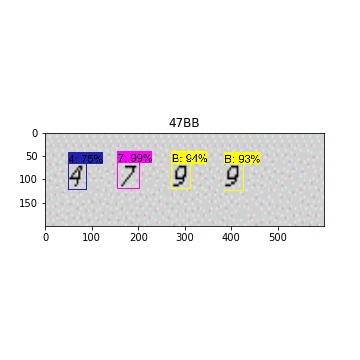

'47BB'

In [19]:
print(captha.dtype, captha.shape)
decode_captcha(captha)
